In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
# Load Electricity price data, 15 minute interval over two years: 2016 and 2017:
import zipfile
with zipfile.ZipFile("C:/Users/anutako/Dropbox/jm2017/data_incubator/Electricity_Prices/rpt.00013061.0000000000000000.20180101.082427782.RTMLZHBSPP_2017.zip") as z:
    with z.open("rpt.00013061.0000000000000000.RTMLZHBSPP_2017.xlsx") as f:
        dset_electr_pr2017 = pd.ExcelFile(f)
with zipfile.ZipFile("C:/Users/anutako/Dropbox/jm2017/data_incubator/Electricity_Prices/rpt.00013061.0000000000000000.20170101.083302375.RTMLZHBSPP_2016.zip") as z:
    with z.open("rpt.00013061.0000000000000000.RTMLZHBSPP_2016.xlsx") as f:
        dset_electr_pr2016 = pd.ExcelFile(f)

In [3]:
# Load Weather Temperature data, hourly, from 2012 till the end of November 2017:
with zipfile.ZipFile("C:/Users/anutako/Dropbox/jm2017/data_incubator/Weather_data/historical-hourly-weather-data.zip") as z:
    with z.open("temperature.csv") as f:
        dset_tempr = pd.read_csv(f, header=0, delimiter=",")
    with z.open("weather_description.csv") as f:
        dset_weather_descr = pd.read_csv(f, header=0, delimiter=",")
    with z.open("wind_direction.csv") as f:
        dset_wind_dir = pd.read_csv(f, header=0, delimiter=",")
    with z.open("wind_speed.csv") as f:
        dset_wind_speed = pd.read_csv(f, header=0, delimiter=",")

In [4]:
#Create one datasets for Electricity prices out of two
sh_names2016  = dset_electr_pr2016.sheet_names
sh_names_len = len(sh_names2016)
dset = pd.DataFrame([])
for i in range(sh_names_len):
    dset = dset.append(dset_electr_pr2016.parse(sh_names2016[i]))
sh_names2017  = dset_electr_pr2017.sheet_names
sh_names_len = len(sh_names2017)
for i in range(sh_names_len):
    dset = dset.append(dset_electr_pr2017.parse(sh_names2017[i]))
dset_shape = dset.shape

In [5]:
# Data manipulation to create index for Electricity Price dataset
dset["Delivery Interval"] = dset["Delivery Interval"].replace([1, 2, 3, 4], [':00', ':15', ':30', ':45'])
dset["Delivery Hour"] = dset["Delivery Hour"].replace(range(1,25), range(24))
dset["Delivery Time"] = dset["Delivery Date"].astype('str') + ' ' +dset["Delivery Hour"].astype(str) + dset["Delivery Interval"]
dset["Delivery Time"] = pd.to_datetime(dset["Delivery Time"])
dset = dset.drop(columns = ["Delivery Date", "Delivery Hour", "Delivery Interval" ])
dset.set_index("Delivery Time" , inplace=True)

In [6]:
# Extract data for Houston Settlement Point
SPnames = dset["Settlement Point Name"].unique()
print(SPnames)
dset_houston = dset[dset["Settlement Point Name"] == SPnames[1]]
dset_houston.describe()

['HB_BUSAVG' 'HB_HOUSTON' 'HB_HUBAVG' 'HB_NORTH' 'HB_SOUTH' 'HB_WEST'
 'LZ_AEN' 'LZ_CPS' 'LZ_HOUSTON' 'LZ_LCRA' 'LZ_NORTH' 'LZ_RAYBN' 'LZ_SOUTH'
 'LZ_WEST' nan]


,Settlement Point Price
count,70176.000000
mean,25.790757
std,57.466030
min,-96.680000
25%,17.150000
50%,19.860000
75%,24.260000
max,3159.680000


In [7]:
price_HF = dset_houston["Settlement Point Price"]
print(price_HF.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99]))

price_quantile99 = price_HF.quantile(q=0.99)
price_quantile97 = price_HF.quantile(q=0.97)
price_quantile90 = price_HF.quantile(q=0.90)
price_quantile05 = price_HF.quantile(q=0.05)
price_quantile02 = price_HF.quantile(q=0.02)

count    70176.000000
mean        25.790757
std         57.466030
min        -96.680000
1%          -0.030000
5%          11.600000
10%         14.110000
25%         17.150000
50%         19.860000
75%         24.260000
90%         31.470000
95%         37.662500
97%         47.397500
99%        130.552500
max       3159.680000
Name: Settlement Point Price, dtype: float64


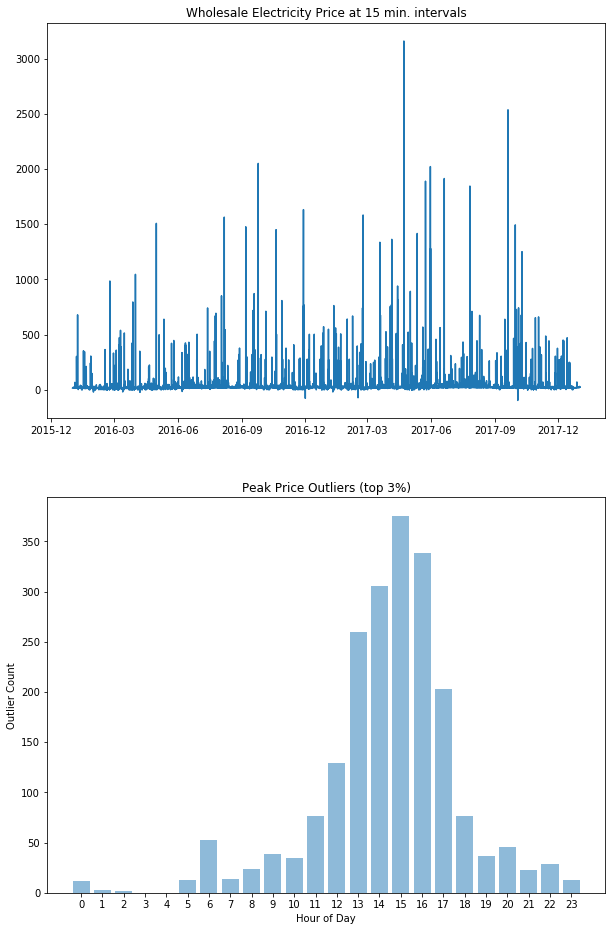

In [8]:
price_outlier99 = price_HF[price_HF>price_quantile99 ]
price_outlier97 = price_HF[price_HF>price_quantile97 ]
price_outlier90 = price_HF[price_HF>price_quantile90 ]
price_outlier02 = price_HF[price_HF<price_quantile02 ]
hour_dist_99 = price_outlier99.groupby(price_outlier99.index.hour).count().rename('Hour_Dist_99')
hour_dist_97 = price_outlier97.groupby(price_outlier97.index.hour).count().rename('Hour_Dist_97')
hour_dist_90 = price_outlier90.groupby(price_outlier90.index.hour).count().rename('Hour_Dist_90')
hour_dist_02 = price_outlier02.groupby(price_outlier02.index.hour).count().rename('Hour_Dist_02')

hours_dist = pd.concat([hour_dist_02, hour_dist_90,hour_dist_97,hour_dist_99],axis = 1,join = 'outer')
hours_dist = hours_dist.fillna(0)

objects = tuple([ str(i) for i in range(24) ])
y_pos = np.arange(len(objects))

plt.rcParams['figure.figsize'] = 10, 16

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(price_HF)
plt.title('Wholesale Electricity Price at 15 min. intervals')
plt.subplot(2,1,2)

plt.bar(y_pos, hours_dist['Hour_Dist_97'], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Outlier Count')
plt.xlabel('Hour of Day')
plt.title('Peak Price Outliers (top 3%)')
plt.show()